In [227]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import matplotlib
import pint
from scipy import signal
%matplotlib inline

un = pint.UnitRegistry()
Q = un.Quantity

L_l = 255 * un.millimeter #mm logitud
L_a = 240 * un.millimeter#mm longitud

d_l = 4.6 * un.millimeter#mm diametro
d_a = 4.0 * un.millimeter#mm diametro

er_L = 2 * un.millimeter  #mm
er_d = 0.2 * un.millimeter#mm

r_a = 7850 * un.kilogram/(un.meter**3) #km/m^3 densidad
r_l = 8730 * un.kilogram/(un.meter**3)#km/m^3 densidad

E_l = 110e9 * un.pascal# pa
E_a = 200e9 * un.pascal# pa
#A = area transversal entiendo yo $pi*r^2$

bl = [1.875104, 4.694091, 7.854757, 10.99554]  #beta *L

archivos_laton = []
archivos_acero = []
for i in range(3):
    archivos_acero.append(np.loadtxt('acero_'+ str(i+1) +'.txt', skiprows = 4))
    archivos_laton.append(np.loadtxt('laton_'+ str(i+1) +'.txt', skiprows=  4))
archivos_laton.append(np.loadtxt('laton_4.txt', skiprows=  4))

In [228]:
Izz_l = np.pi*((d_l/2)**4)/4
Izz_a = np.pi*((d_a/2)**4)/4
B_l = np.pi*((d_l/2)**2)*r_l #El factor q va dividiendo en w
B_a = np.pi*((d_a/2)**2)*r_a #El factor q va dividiendo en w

#son las omwgas teoricas
w_l = []
w_a = [] 
for i in bl:#ver si bl es igual para ambos o no
    w_l.append((np.sqrt(E_l*Izz_l/B_l)*(i/L_l)**2).to(1/un.second)) 
    w_a.append((np.sqrt(E_a*Izz_a/B_a)*(i/L_a)**2).to(1/un.second))

<IPython.core.display.Javascript object>


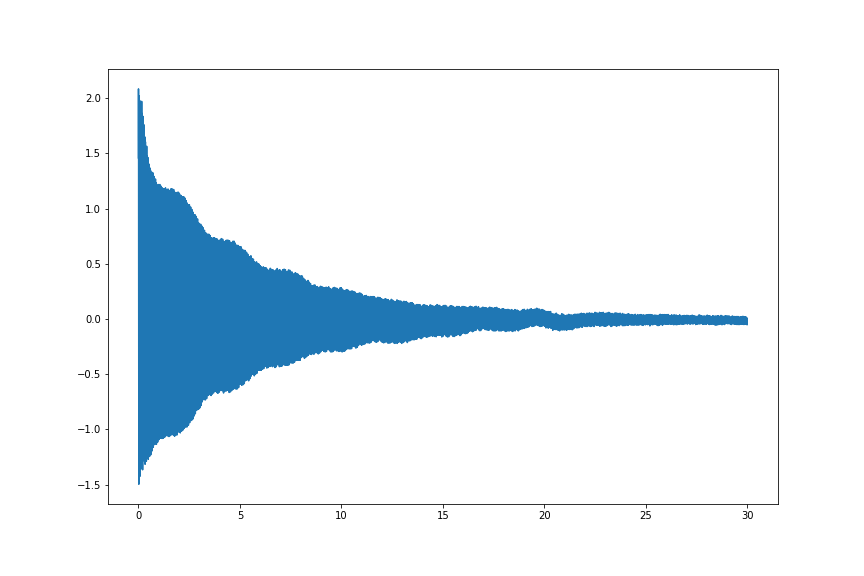

In [229]:
#primero grafico los datos del laton
%matplotlib nbagg
data = np.array(archivos_laton[2])

fig, ax = plt.subplots(1, figsize=(12,8))

t_in=0
t_fin=30000
data = data[t_in:t_fin,:]
data[:,1] = data[:,1] - np.mean(data[:,1]) #le saco la componente constante a la señal
data[:,0] = data[:,0] - data[0, 0] #le resto el tiempo donde recoté

ax.plot(data[:,0], data[:,1])
plt.show()

<IPython.core.display.Javascript object>


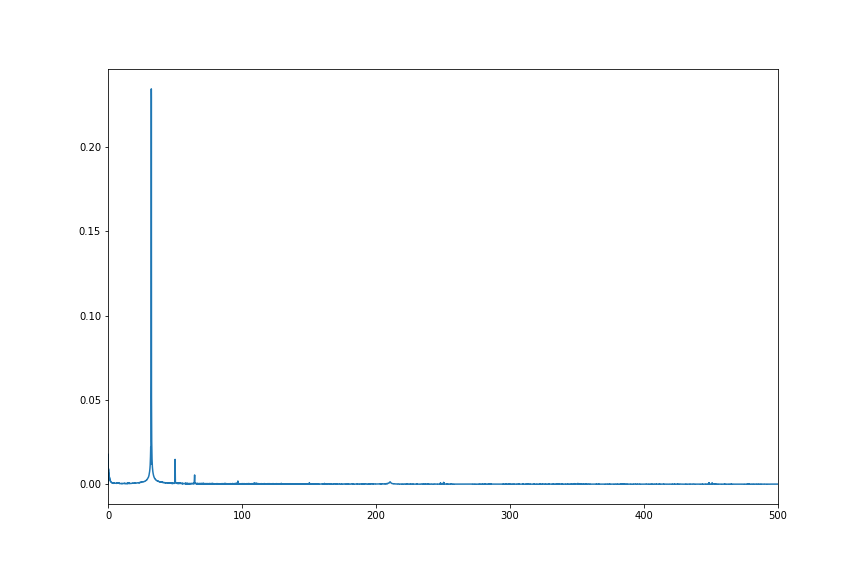

In [230]:
#filtro fourier

t_data = data[:,0]
v_data = data[:,1]

N = len(t_data)
t_max = t_data[-1]

fsamp = N/t_max

v_fft = np.fft.fft(v_data)
v_fft_2 = 2/N * np.abs(v_fft[:N//2])

frecuencia = np.linspace(0, fsamp/2, int(N/2))

fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(frecuencia, np.abs(v_fft_2))
ax.set_xlim([0,500])
plt.show()

<IPython.core.display.Javascript object>


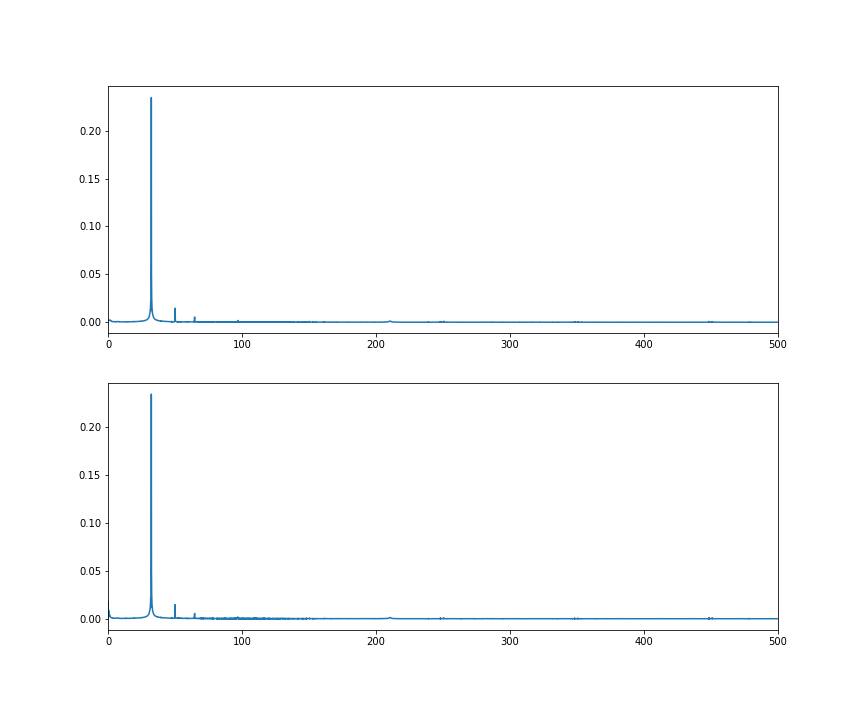

In [232]:
v_fft_filtrado = np.copy(v_fft)
v_fft_2_filtrado = np.copy(v_fft_2)


#for n in range(10):
#    v_fft_filtrado[1390*(n+1) : 1415*(n+1) ] = 0
#    v_fft_2_filtrado[1390*(n+1) : 1415*(n+1)] = 0


v_fft_filtrado[0:50] = 0.002
v_fft_2_filtrado[0:50] = 0.002



fig, ax = plt.subplots(2, figsize=(12,10))
ax[0].plot(frecuencia, np.abs(v_fft_2_filtrado))
ax[1].plot(frecuencia, np.abs(v_fft_2))
ax[0].set_xlim([0,500])
ax[1].set_xlim([0,500])
plt.show()

<IPython.core.display.Javascript object>


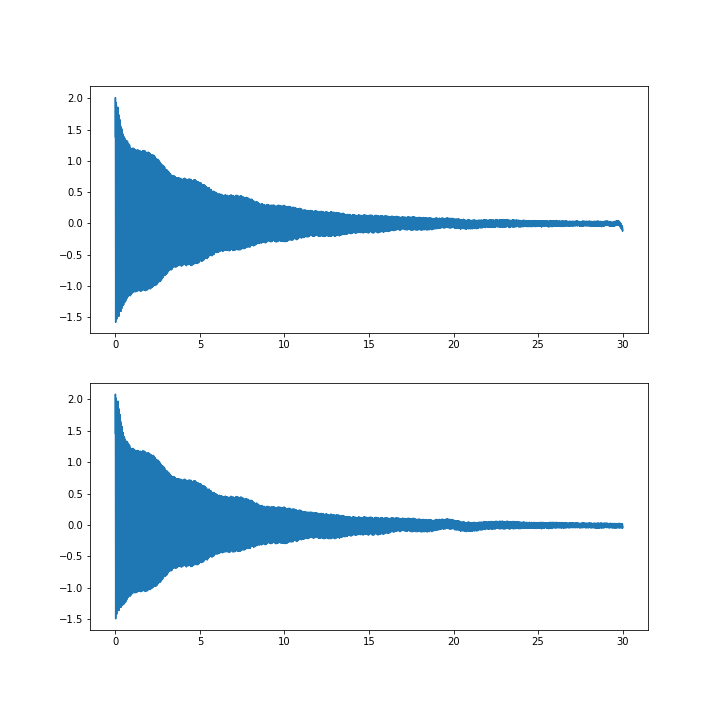

/home/dina/environments/labo_4/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [233]:
anti_transf_filt = np.fft.ifft(v_fft_filtrado)
anti_transf = np.fft.ifft(v_fft)

fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(t_data, anti_transf_filt)
ax[1].plot(t_data, v_data)
plt.show()

In [234]:
def v(t, A, w, fi, seda):
    v = np.zeros(t.size)
    for i in range(len(A)):
        print(i)
        v = v + A[i] * np.sin(w[i] * t + fi[i]) * np.exp(-seda * w[i] * t)
    amp_luz = 0.01 * un.volts
    w_luz = 1 * 50 / un.second
    v = v + amp_luz * np.sin(2*np.pi * w_luz * t)
    return v

tstep = 0.00001
t = np.linspace(0, 28, int(1/tstep)) * un.second
fi = [0,0,0,0] * un.radian
A = np.array([1.5,0.1,0.1,0]) * un.volts

w = w_a
print(np.array(w_a, dtype=object) / (2*np.pi))

seda = 0.00075

w = np.array(w, dtype=object) * (1 - seda * np.ones(len(w)))
print(w)
v = v(t, A, w, fi, seda)



[<Quantity(49.0375245, '1 / second')> <Quantity(307.312925, '1 / second')>
 <Quantity(860.485043, '1 / second')> <Quantity(1686.20721, '1 / second')>]
[<Quantity(307.88077, '1 / second')> <Quantity(1929.45588, '1 / second')>
 <Quantity(5402.53204, '1 / second')> <Quantity(10586.8063, '1 / second')>]
0
1
2
3


<ipython-input-234-db8b899c3b9f>:17: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  print(np.array(w_a, dtype=object) / (2*np.pi))
<ipython-input-234-db8b899c3b9f>:21: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  w = np.array(w, dtype=object) * (1 - seda * np.ones(len(w)))


<ipython-input-235-e9b6968f1db4>:1: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  v_fft_teorico = np.fft.fft(np.array(v))


<IPython.core.display.Javascript object>


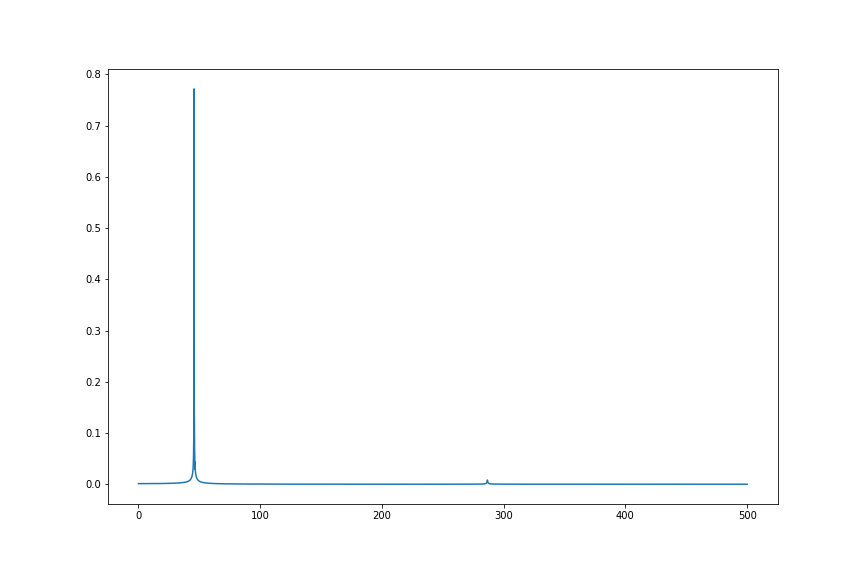

In [235]:
v_fft_teorico = np.fft.fft(np.array(v))
v_fft_2_teorico = 2/N * np.abs(v_fft_teorico[:N//2])

frecuencia = np.linspace(0, fsamp/2, int(N/2))

fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(frecuencia, np.abs(v_fft_2_teorico))
#ax.set_xlim([0,500])
plt.show()

<IPython.core.display.Javascript object>


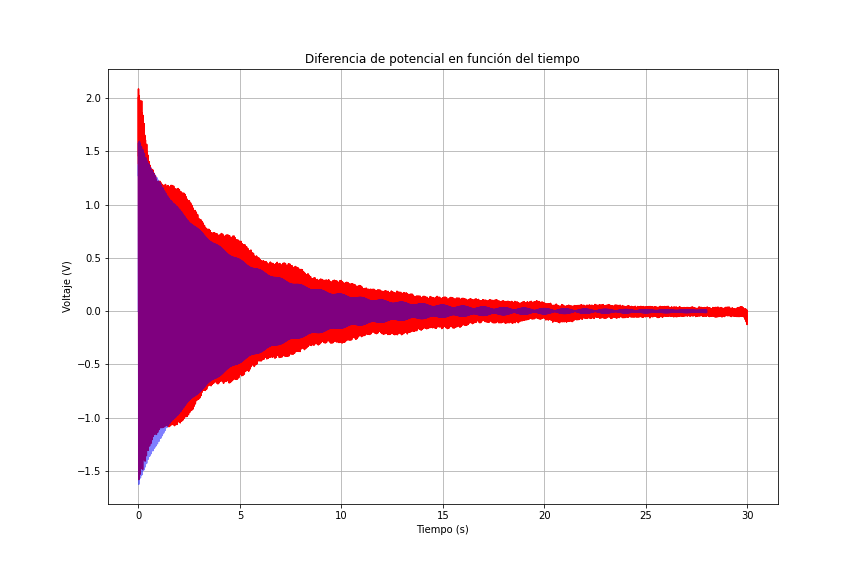

<ipython-input-236-0be109bec850>:4: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  t_graf = np.array(t)
<ipython-input-236-0be109bec850>:5: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  v_graf = np.array(v) #+ offset
/home/dina/environments/labo_4/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/dina/environments/labo_4/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [236]:
%matplotlib nbagg
fig, ax = plt.subplots(1, figsize=(12,8))

t_graf = np.array(t)
v_graf = np.array(v) #+ offset

ax.plot(t_data, anti_transf_filt, color='red')
ax.plot(t_data, anti_transf, 'red')
ax.plot(t_graf, v_graf, color='blue', alpha=0.5)
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Voltaje (V)")
ax.grid()
ax.set_title("Diferencia de potencial en función del tiempo")
plt.show()
